# WGAN

## Import Modules

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
# Visualization Tool requires "pip install visdom" (https://github.com/facebookresearch/visdom)
# from visdom_utils import VisFunc
# vf = VisFunc(enval='WGAN')

## MNIST Dataset

In [13]:
batch_size = 100
dataset = datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Define Model

In [14]:
z_dim = 10

# Generator
G = nn.Sequential(
    nn.Linear(z_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Sigmoid() #instead of Tanh()
    )

# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    #nn.Sigmoid()
    )


def weight_init(m): 
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = np.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)

D.apply(weight_init)
G.apply(weight_init)
G.cuda()
D.cuda()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

## Defin Optimizer

In [15]:
# Optimizers
G_solver = optim.RMSprop(G.parameters(), lr=0.0005)
D_solver = optim.RMSprop(D.parameters(), lr=0.0005)

## Training

Epoch 0 | [300/600] | D_loss: -0.37 | G_loss: 0.42


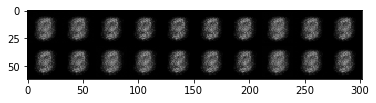

Epoch 0 | [600/600] | D_loss: -0.29 | G_loss: 0.07


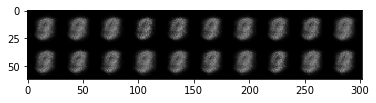

Epoch 1 | [300/600] | D_loss: -0.37 | G_loss: 0.04


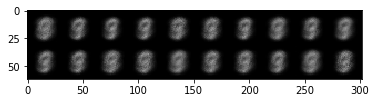

Epoch 1 | [600/600] | D_loss: -0.45 | G_loss: 0.07


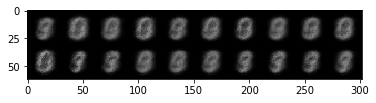

Epoch 2 | [300/600] | D_loss: -0.43 | G_loss: 0.24


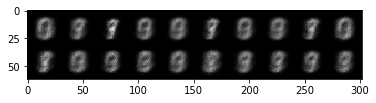

Epoch 2 | [600/600] | D_loss: -0.51 | G_loss: 0.16


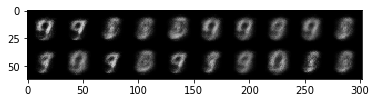

Epoch 3 | [300/600] | D_loss: -0.40 | G_loss: 0.25


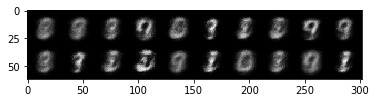

Epoch 3 | [600/600] | D_loss: -0.55 | G_loss: 0.04


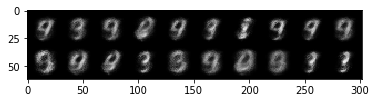

Epoch 4 | [300/600] | D_loss: -0.33 | G_loss: -0.02


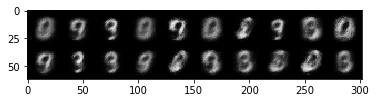

Epoch 4 | [600/600] | D_loss: -0.35 | G_loss: 0.08


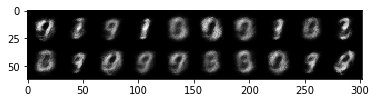

Epoch 5 | [300/600] | D_loss: -0.25 | G_loss: -0.07


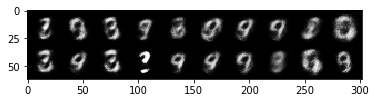

Epoch 5 | [600/600] | D_loss: -0.36 | G_loss: -0.04


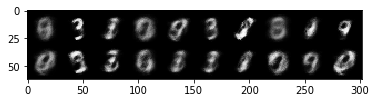

Epoch 6 | [300/600] | D_loss: -0.26 | G_loss: 0.03


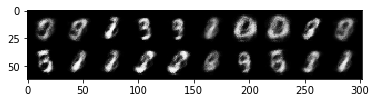

Epoch 6 | [600/600] | D_loss: -0.33 | G_loss: 0.07


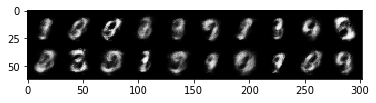

Epoch 7 | [300/600] | D_loss: -0.22 | G_loss: -0.06


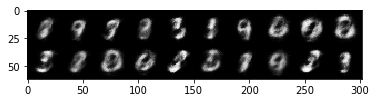

Epoch 7 | [600/600] | D_loss: -0.33 | G_loss: 0.13


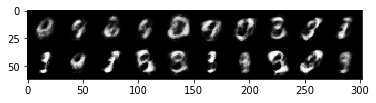

Epoch 8 | [300/600] | D_loss: -0.19 | G_loss: -0.06


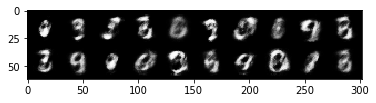

Epoch 8 | [600/600] | D_loss: -0.36 | G_loss: 0.26


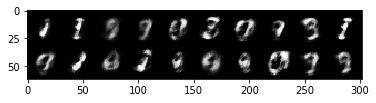

Epoch 9 | [300/600] | D_loss: -0.15 | G_loss: -0.08


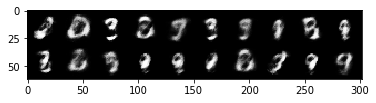

Epoch 9 | [600/600] | D_loss: -0.32 | G_loss: 0.21


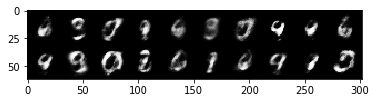

Epoch 10 | [300/600] | D_loss: -0.14 | G_loss: -0.05


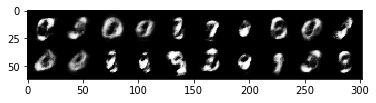

Epoch 10 | [600/600] | D_loss: -0.28 | G_loss: 0.21


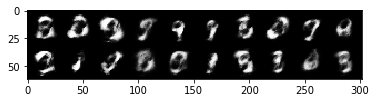

Epoch 11 | [300/600] | D_loss: -0.13 | G_loss: -0.11


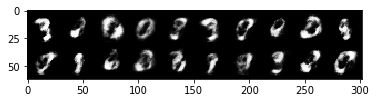

Epoch 11 | [600/600] | D_loss: -0.29 | G_loss: 0.19


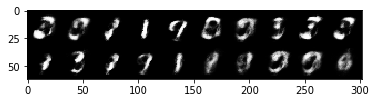

Epoch 12 | [300/600] | D_loss: -0.19 | G_loss: -0.17


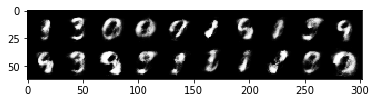

Epoch 12 | [600/600] | D_loss: -0.13 | G_loss: -0.18


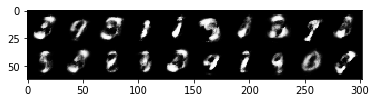

Epoch 13 | [300/600] | D_loss: -0.15 | G_loss: -0.16


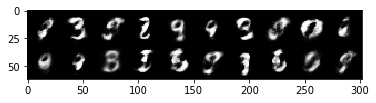

Epoch 13 | [600/600] | D_loss: -0.29 | G_loss: 0.09


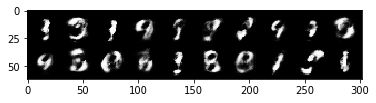

Epoch 14 | [300/600] | D_loss: -0.17 | G_loss: -0.17


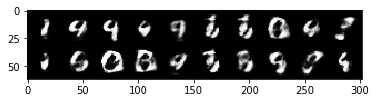

Epoch 14 | [600/600] | D_loss: -0.25 | G_loss: 0.06


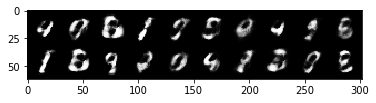

Epoch 15 | [300/600] | D_loss: -0.14 | G_loss: -0.13


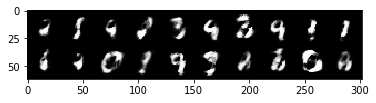

Epoch 15 | [600/600] | D_loss: -0.31 | G_loss: -0.23


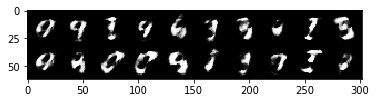

Epoch 16 | [300/600] | D_loss: -0.14 | G_loss: -0.17


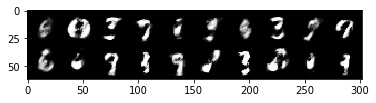

Epoch 16 | [600/600] | D_loss: -0.23 | G_loss: -0.08


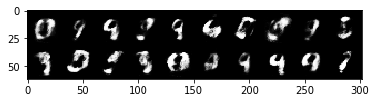

Epoch 17 | [300/600] | D_loss: -0.12 | G_loss: -0.17


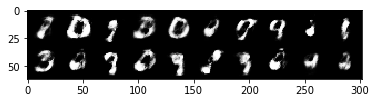

Epoch 17 | [600/600] | D_loss: -0.17 | G_loss: -0.26


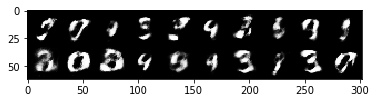

Epoch 18 | [300/600] | D_loss: -0.12 | G_loss: -0.16


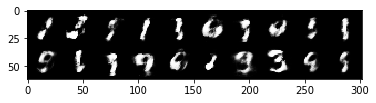

Epoch 18 | [600/600] | D_loss: -0.14 | G_loss: -0.38


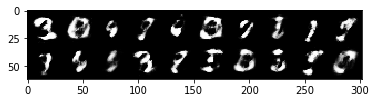

Epoch 19 | [300/600] | D_loss: -0.18 | G_loss: 0.19


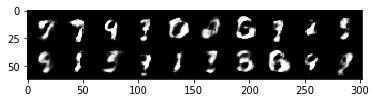

Epoch 19 | [600/600] | D_loss: -0.19 | G_loss: 0.14


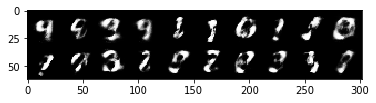

Epoch 20 | [300/600] | D_loss: -0.15 | G_loss: 0.20


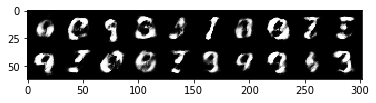

Epoch 20 | [600/600] | D_loss: -0.37 | G_loss: 0.17


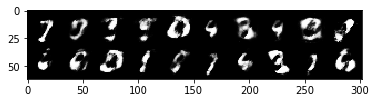

Epoch 21 | [300/600] | D_loss: -0.10 | G_loss: -0.08


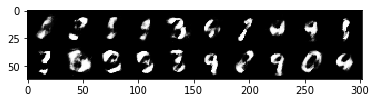

Epoch 21 | [600/600] | D_loss: -0.34 | G_loss: -0.17


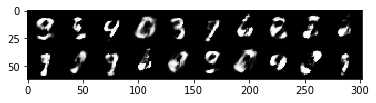

Epoch 22 | [300/600] | D_loss: -0.14 | G_loss: -0.17


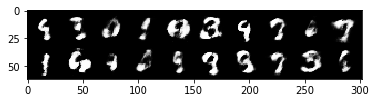

Epoch 22 | [600/600] | D_loss: -0.26 | G_loss: -0.04


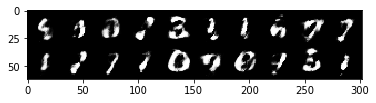

Epoch 23 | [300/600] | D_loss: -0.09 | G_loss: -0.10


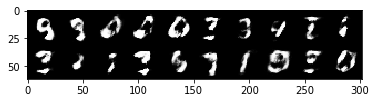

Epoch 23 | [600/600] | D_loss: -0.38 | G_loss: -0.18


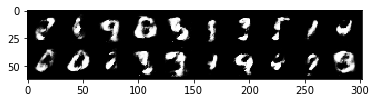

Epoch 24 | [300/600] | D_loss: -0.11 | G_loss: -0.18


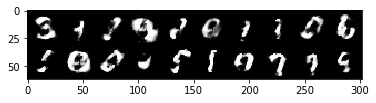

Epoch 24 | [600/600] | D_loss: -0.21 | G_loss: 0.06


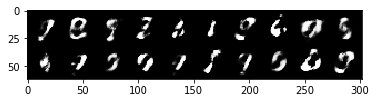

Epoch 25 | [300/600] | D_loss: -0.12 | G_loss: -0.04


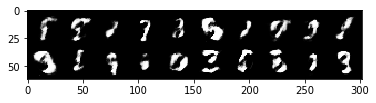

Epoch 25 | [600/600] | D_loss: -0.14 | G_loss: -0.28


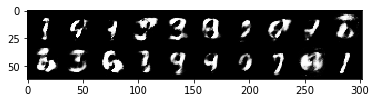

Epoch 26 | [300/600] | D_loss: -0.11 | G_loss: -0.07


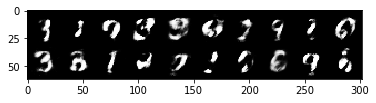

Epoch 26 | [600/600] | D_loss: -0.26 | G_loss: -0.11


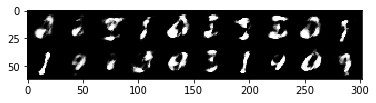

Epoch 27 | [300/600] | D_loss: -0.12 | G_loss: -0.12


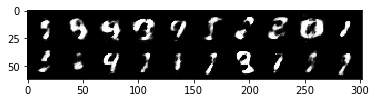

Epoch 27 | [600/600] | D_loss: -0.19 | G_loss: -0.06


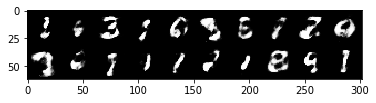

Epoch 28 | [300/600] | D_loss: -0.13 | G_loss: -0.10


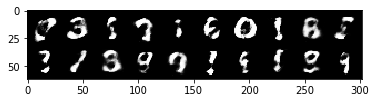

Epoch 28 | [600/600] | D_loss: -0.24 | G_loss: -0.15


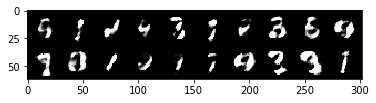

Epoch 29 | [300/600] | D_loss: -0.10 | G_loss: -0.08


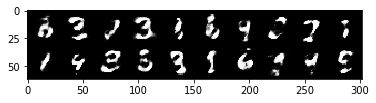

Epoch 29 | [600/600] | D_loss: -0.14 | G_loss: -0.32


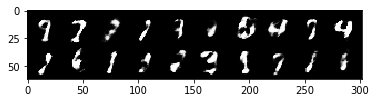

Epoch 30 | [300/600] | D_loss: -0.10 | G_loss: -0.07


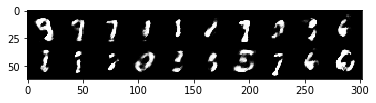

Epoch 30 | [600/600] | D_loss: -0.08 | G_loss: -0.34


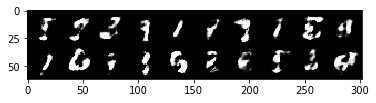

Epoch 31 | [300/600] | D_loss: -0.11 | G_loss: -0.09


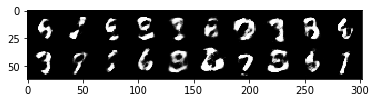

Epoch 31 | [600/600] | D_loss: -0.23 | G_loss: -0.01


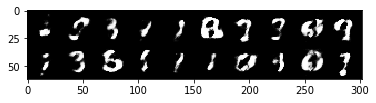

Epoch 32 | [300/600] | D_loss: -0.09 | G_loss: -0.04


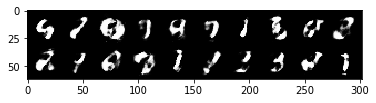

Epoch 32 | [600/600] | D_loss: -0.18 | G_loss: -0.41


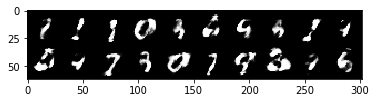

Epoch 33 | [300/600] | D_loss: -0.11 | G_loss: -0.10


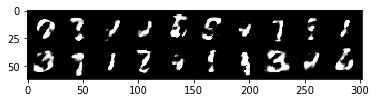

Epoch 33 | [600/600] | D_loss: -0.22 | G_loss: -0.29


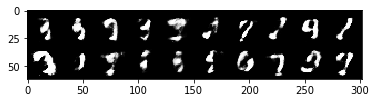

Epoch 34 | [300/600] | D_loss: -0.07 | G_loss: -0.02


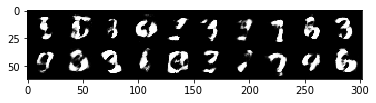

Epoch 34 | [600/600] | D_loss: -0.19 | G_loss: -0.54


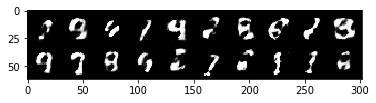

Epoch 35 | [300/600] | D_loss: -0.12 | G_loss: -0.09


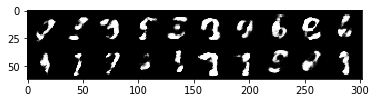

Epoch 35 | [600/600] | D_loss: -0.23 | G_loss: -0.17


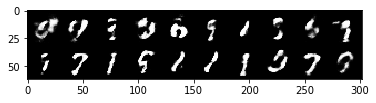

Epoch 36 | [300/600] | D_loss: -0.12 | G_loss: -0.04


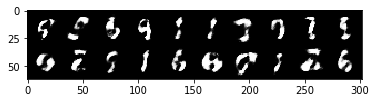

Epoch 36 | [600/600] | D_loss: -0.30 | G_loss: -0.16


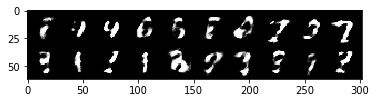

Epoch 37 | [300/600] | D_loss: -0.11 | G_loss: -0.09


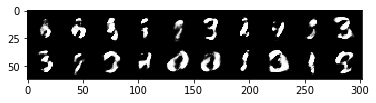

Epoch 37 | [600/600] | D_loss: -0.20 | G_loss: -0.30


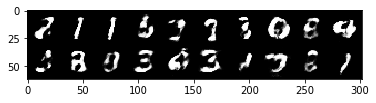

Epoch 38 | [300/600] | D_loss: -0.11 | G_loss: -0.08


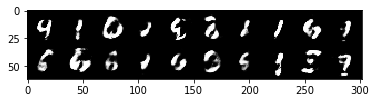

Epoch 38 | [600/600] | D_loss: -0.20 | G_loss: -0.32


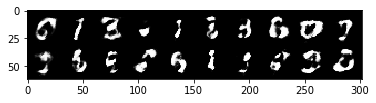

Epoch 39 | [300/600] | D_loss: -0.08 | G_loss: -0.06


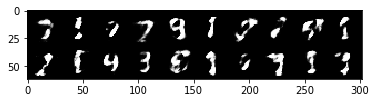

Epoch 39 | [600/600] | D_loss: -0.18 | G_loss: -0.66


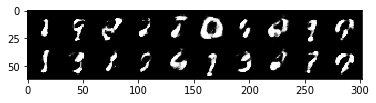

Epoch 40 | [300/600] | D_loss: -0.09 | G_loss: -0.06


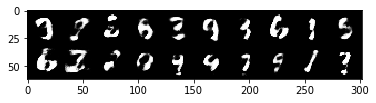

Epoch 40 | [600/600] | D_loss: -0.08 | G_loss: -0.37


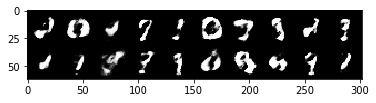

Epoch 41 | [300/600] | D_loss: -0.08 | G_loss: -0.06


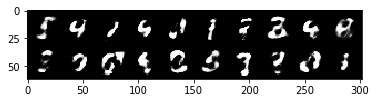

Epoch 41 | [600/600] | D_loss: -0.13 | G_loss: -0.47


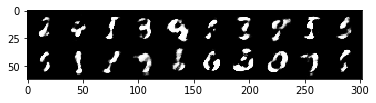

Epoch 42 | [300/600] | D_loss: -0.09 | G_loss: -0.02


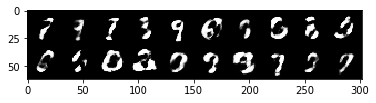

Epoch 42 | [600/600] | D_loss: -0.24 | G_loss: -0.18


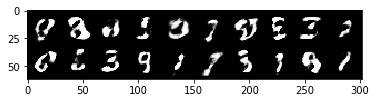

Epoch 43 | [300/600] | D_loss: -0.09 | G_loss: -0.08


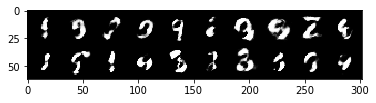

Epoch 43 | [600/600] | D_loss: -0.15 | G_loss: -0.54


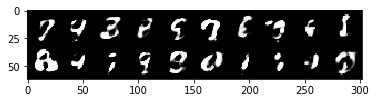

Epoch 44 | [300/600] | D_loss: -0.09 | G_loss: -0.14


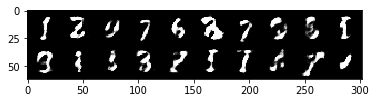

Epoch 44 | [600/600] | D_loss: -0.12 | G_loss: -0.75


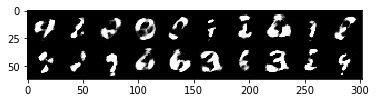

Epoch 45 | [300/600] | D_loss: -0.10 | G_loss: -0.17


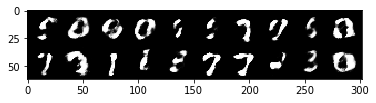

Epoch 45 | [600/600] | D_loss: -0.11 | G_loss: -0.45


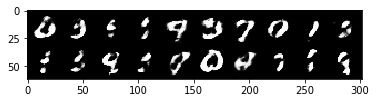

Epoch 46 | [300/600] | D_loss: -0.09 | G_loss: -0.03


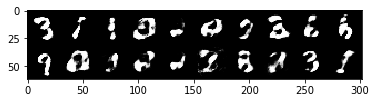

Epoch 46 | [600/600] | D_loss: -0.21 | G_loss: -0.26


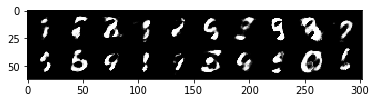

Epoch 47 | [300/600] | D_loss: -0.05 | G_loss: -0.05


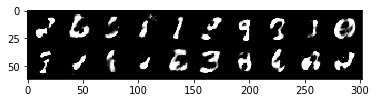

Epoch 47 | [600/600] | D_loss: -0.19 | G_loss: -0.09


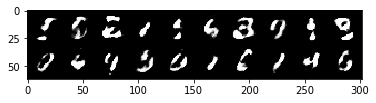

Epoch 48 | [300/600] | D_loss: -0.06 | G_loss: -0.06


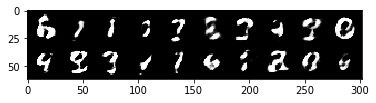

Epoch 48 | [600/600] | D_loss: -0.19 | G_loss: -0.42


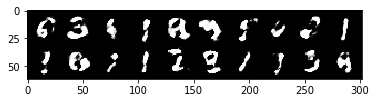

Epoch 49 | [300/600] | D_loss: -0.08 | G_loss: 0.03


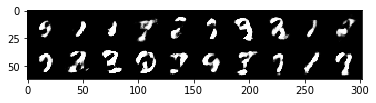

Epoch 49 | [600/600] | D_loss: -0.28 | G_loss: -0.12


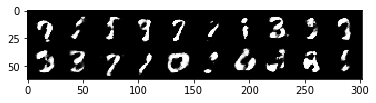

Epoch 50 | [300/600] | D_loss: -0.06 | G_loss: -0.06


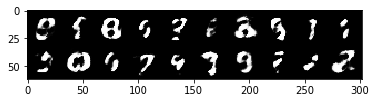

Epoch 50 | [600/600] | D_loss: -0.13 | G_loss: -0.53


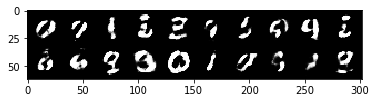

Epoch 51 | [300/600] | D_loss: -0.09 | G_loss: -0.09


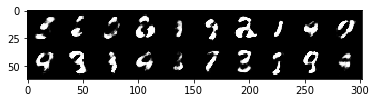

Epoch 51 | [600/600] | D_loss: -0.19 | G_loss: -0.16


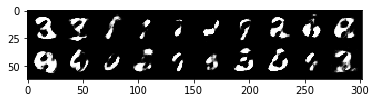

Epoch 52 | [300/600] | D_loss: -0.09 | G_loss: -0.12


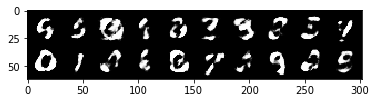

Epoch 52 | [600/600] | D_loss: -0.17 | G_loss: -0.53


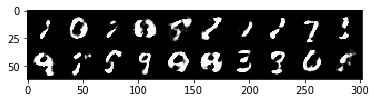

Epoch 53 | [300/600] | D_loss: -0.05 | G_loss: -0.02


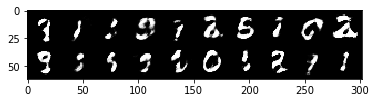

Epoch 53 | [600/600] | D_loss: -0.11 | G_loss: -0.52


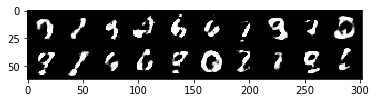

Epoch 54 | [300/600] | D_loss: -0.04 | G_loss: -0.07


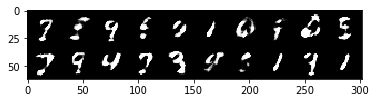

Epoch 54 | [600/600] | D_loss: -0.12 | G_loss: -0.66


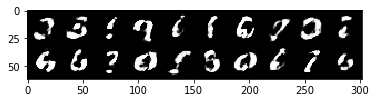

Epoch 55 | [300/600] | D_loss: -0.08 | G_loss: -0.01


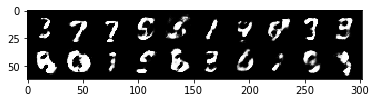

Epoch 55 | [600/600] | D_loss: -0.18 | G_loss: -0.54


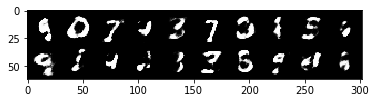

Epoch 56 | [300/600] | D_loss: -0.07 | G_loss: -0.08


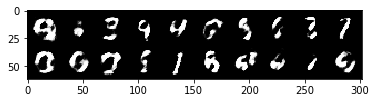

Epoch 56 | [600/600] | D_loss: -0.14 | G_loss: -0.44


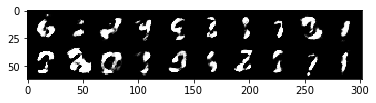

Epoch 57 | [300/600] | D_loss: -0.09 | G_loss: -0.07


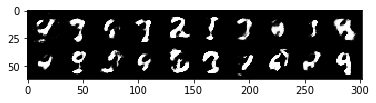

Epoch 57 | [600/600] | D_loss: -0.25 | G_loss: -0.32


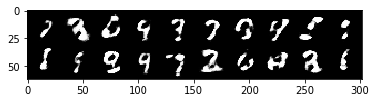

Epoch 58 | [300/600] | D_loss: -0.07 | G_loss: 0.01


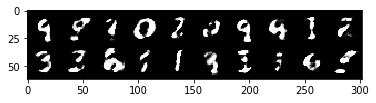

Epoch 58 | [600/600] | D_loss: -0.34 | G_loss: -0.34


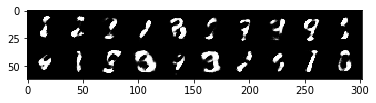

Epoch 59 | [300/600] | D_loss: -0.06 | G_loss: 0.01


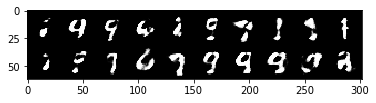

Epoch 59 | [600/600] | D_loss: -0.08 | G_loss: -0.69


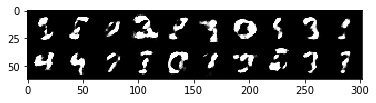

Epoch 60 | [300/600] | D_loss: -0.09 | G_loss: -0.03


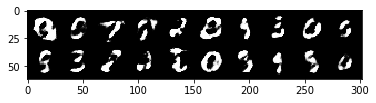

Epoch 60 | [600/600] | D_loss: -0.14 | G_loss: -0.64


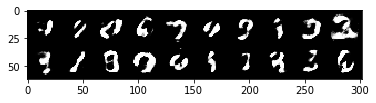

Epoch 61 | [300/600] | D_loss: -0.07 | G_loss: -0.02


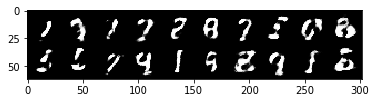

Epoch 61 | [600/600] | D_loss: -0.29 | G_loss: -0.40


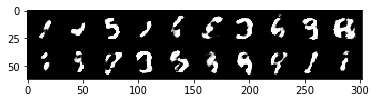

Epoch 62 | [300/600] | D_loss: -0.07 | G_loss: -0.03


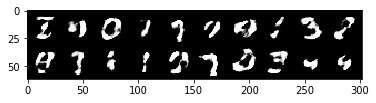

Epoch 62 | [600/600] | D_loss: -0.19 | G_loss: -0.48


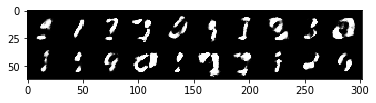

Epoch 63 | [300/600] | D_loss: -0.08 | G_loss: -0.10


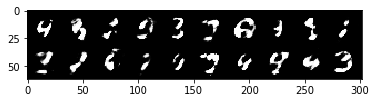

Epoch 63 | [600/600] | D_loss: -0.20 | G_loss: -0.37


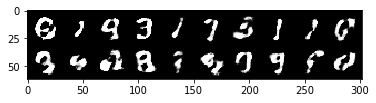

Epoch 64 | [300/600] | D_loss: -0.06 | G_loss: 0.03


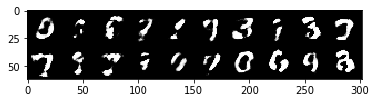

Epoch 64 | [600/600] | D_loss: -0.13 | G_loss: -0.42


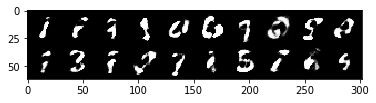

Epoch 65 | [300/600] | D_loss: -0.08 | G_loss: -0.07


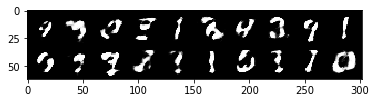

Epoch 65 | [600/600] | D_loss: -0.23 | G_loss: -0.28


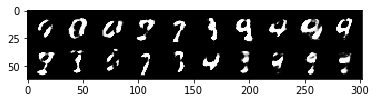

Epoch 66 | [300/600] | D_loss: -0.04 | G_loss: -0.00


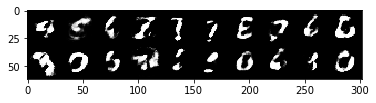

Epoch 66 | [600/600] | D_loss: -0.13 | G_loss: -0.39


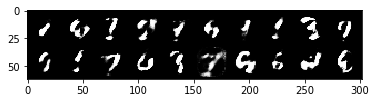

Epoch 67 | [300/600] | D_loss: -0.06 | G_loss: -0.02


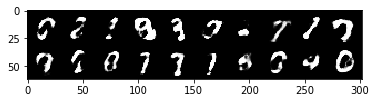

Epoch 67 | [600/600] | D_loss: -0.21 | G_loss: -0.54


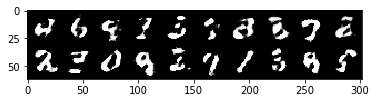

Epoch 68 | [300/600] | D_loss: -0.05 | G_loss: -0.02


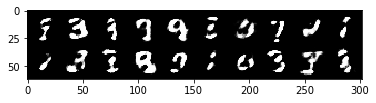

Epoch 68 | [600/600] | D_loss: -0.25 | G_loss: -0.13


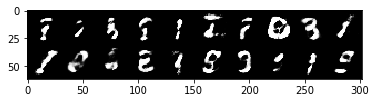

Epoch 69 | [300/600] | D_loss: -0.05 | G_loss: 0.02


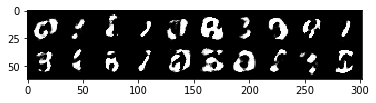

Epoch 69 | [600/600] | D_loss: -0.14 | G_loss: -0.58


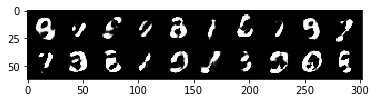

Epoch 70 | [300/600] | D_loss: -0.05 | G_loss: -0.04


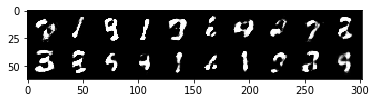

Epoch 70 | [600/600] | D_loss: -0.18 | G_loss: -0.50


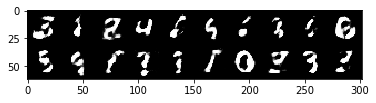

Epoch 71 | [300/600] | D_loss: -0.10 | G_loss: -0.11


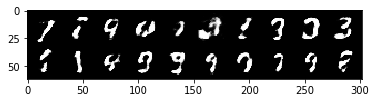

Epoch 71 | [600/600] | D_loss: -0.27 | G_loss: -0.02


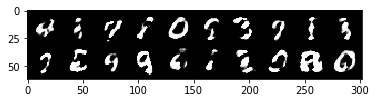

Epoch 72 | [300/600] | D_loss: -0.04 | G_loss: -0.11


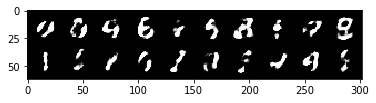

Epoch 72 | [600/600] | D_loss: -0.18 | G_loss: -0.43


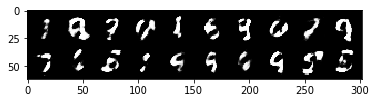

Epoch 73 | [300/600] | D_loss: -0.09 | G_loss: -0.01


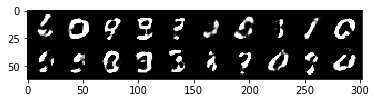

Epoch 73 | [600/600] | D_loss: -0.20 | G_loss: -0.13


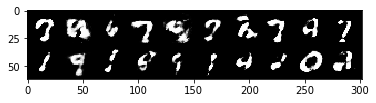

Epoch 74 | [300/600] | D_loss: -0.04 | G_loss: -0.07


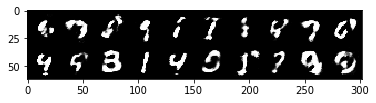

Epoch 74 | [600/600] | D_loss: -0.28 | G_loss: -0.21


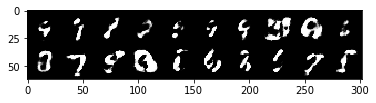

Epoch 75 | [300/600] | D_loss: -0.04 | G_loss: -0.03


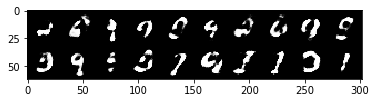

Epoch 75 | [600/600] | D_loss: -0.20 | G_loss: -0.12


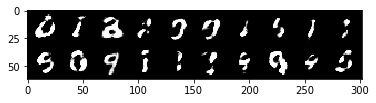

Epoch 76 | [300/600] | D_loss: -0.05 | G_loss: 0.03


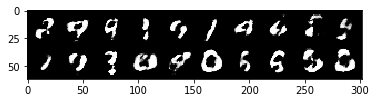

Epoch 76 | [600/600] | D_loss: -0.21 | G_loss: -0.22


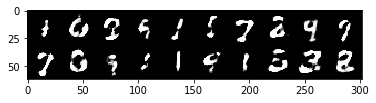

Epoch 77 | [300/600] | D_loss: -0.08 | G_loss: 0.12


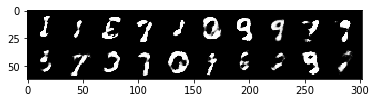

Epoch 77 | [600/600] | D_loss: -0.15 | G_loss: -0.35


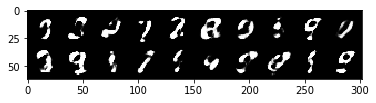

Epoch 78 | [300/600] | D_loss: -0.08 | G_loss: 0.06


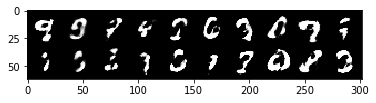

Epoch 78 | [600/600] | D_loss: -0.42 | G_loss: -0.13


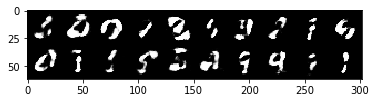

Epoch 79 | [300/600] | D_loss: -0.01 | G_loss: -0.16


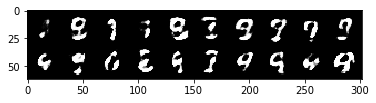

Epoch 79 | [600/600] | D_loss: -0.26 | G_loss: -0.19


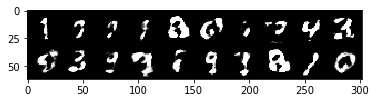

Epoch 80 | [300/600] | D_loss: -0.08 | G_loss: -0.05


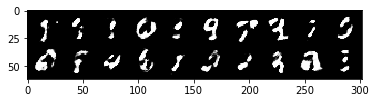

Epoch 80 | [600/600] | D_loss: -0.29 | G_loss: -0.13


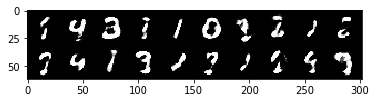

Epoch 81 | [300/600] | D_loss: -0.02 | G_loss: -0.08


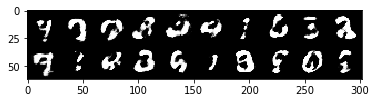

Epoch 81 | [600/600] | D_loss: -0.23 | G_loss: -0.11


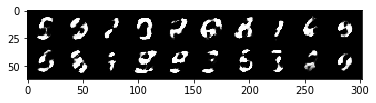

Epoch 82 | [300/600] | D_loss: -0.03 | G_loss: 0.06


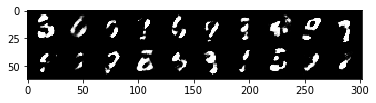

Epoch 82 | [600/600] | D_loss: -0.13 | G_loss: -0.54


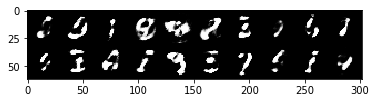

Epoch 83 | [300/600] | D_loss: -0.02 | G_loss: -0.05


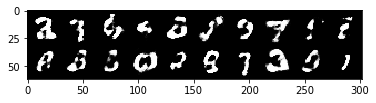

Epoch 83 | [600/600] | D_loss: -0.21 | G_loss: -0.28


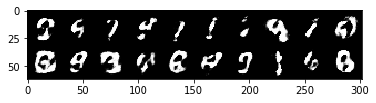

Epoch 84 | [300/600] | D_loss: -0.04 | G_loss: -0.07


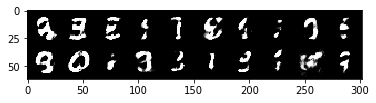

Epoch 84 | [600/600] | D_loss: -0.39 | G_loss: 0.10


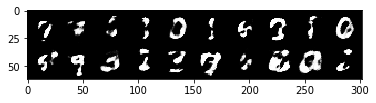

Epoch 85 | [300/600] | D_loss: -0.06 | G_loss: -0.03


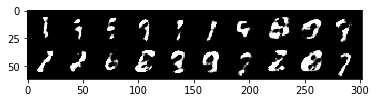

Epoch 85 | [600/600] | D_loss: -0.33 | G_loss: -0.07


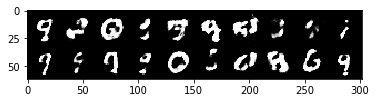

Epoch 86 | [300/600] | D_loss: 0.04 | G_loss: -0.23


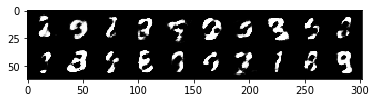

Epoch 86 | [600/600] | D_loss: -0.30 | G_loss: -0.12


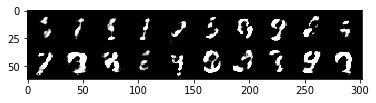

Epoch 87 | [300/600] | D_loss: -0.06 | G_loss: 0.02


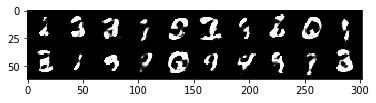

Epoch 87 | [600/600] | D_loss: -0.36 | G_loss: 0.09


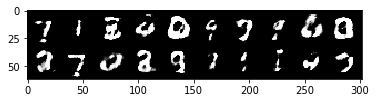

Epoch 88 | [300/600] | D_loss: -0.01 | G_loss: -0.11


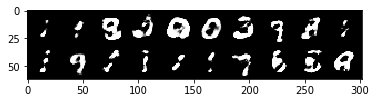

Epoch 88 | [600/600] | D_loss: -0.26 | G_loss: -0.08


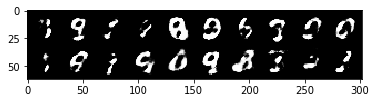

Epoch 89 | [300/600] | D_loss: -0.08 | G_loss: -0.12


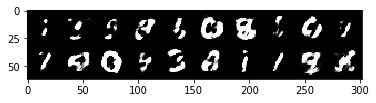

Epoch 89 | [600/600] | D_loss: -0.49 | G_loss: 0.25


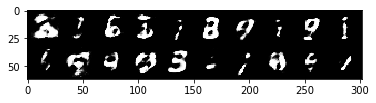

Epoch 90 | [300/600] | D_loss: -0.09 | G_loss: 0.12


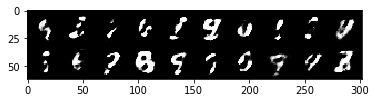

Epoch 90 | [600/600] | D_loss: -0.20 | G_loss: -0.09


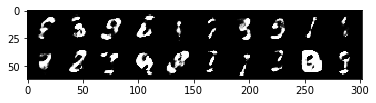

Epoch 91 | [300/600] | D_loss: -0.05 | G_loss: -0.05


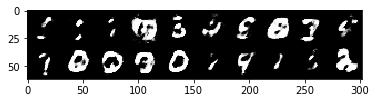

Epoch 91 | [600/600] | D_loss: -0.31 | G_loss: 0.02


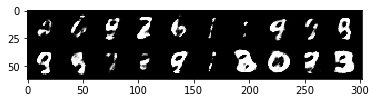

Epoch 92 | [300/600] | D_loss: -0.02 | G_loss: -0.23


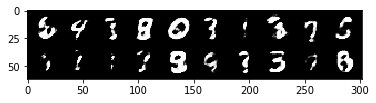

Epoch 92 | [600/600] | D_loss: -0.33 | G_loss: 0.08


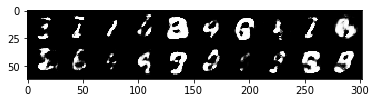

Epoch 93 | [300/600] | D_loss: -0.04 | G_loss: 0.00


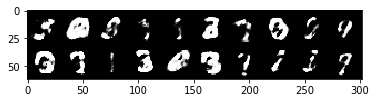

Epoch 93 | [600/600] | D_loss: -0.31 | G_loss: -0.04


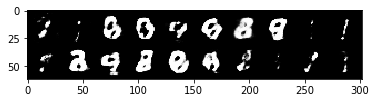

Epoch 94 | [300/600] | D_loss: -0.03 | G_loss: -0.23


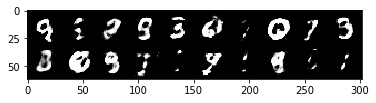

Epoch 94 | [600/600] | D_loss: -0.28 | G_loss: -0.08


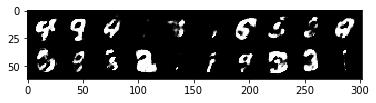

Epoch 95 | [300/600] | D_loss: -0.03 | G_loss: -0.15


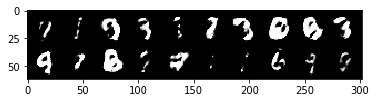

Epoch 95 | [600/600] | D_loss: -0.23 | G_loss: -0.04


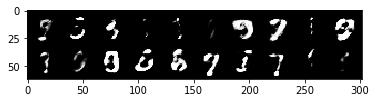

Epoch 96 | [300/600] | D_loss: -0.02 | G_loss: -0.13


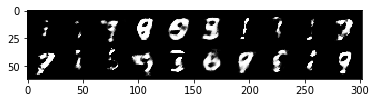

Epoch 96 | [600/600] | D_loss: -0.23 | G_loss: -0.04


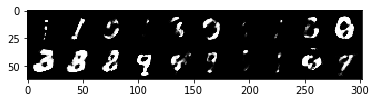

Epoch 97 | [300/600] | D_loss: -0.05 | G_loss: -0.12


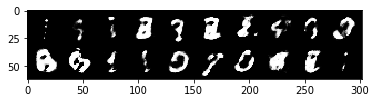

Epoch 97 | [600/600] | D_loss: -0.23 | G_loss: -0.03


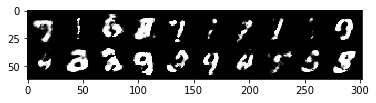

Epoch 98 | [300/600] | D_loss: -0.04 | G_loss: -0.15


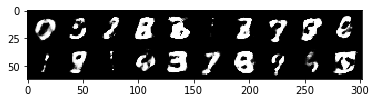

Epoch 98 | [600/600] | D_loss: -0.32 | G_loss: -0.12


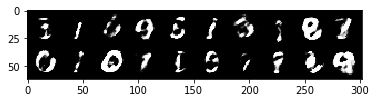

Epoch 99 | [300/600] | D_loss: -0.05 | G_loss: -0.06


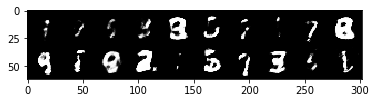

Epoch 99 | [600/600] | D_loss: -0.24 | G_loss: -0.10


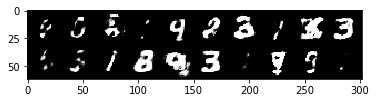

In [16]:
# for epoch in range(20):
#     for num_iters, batch_data in enumerate(dataloader,0):

for epoch in range(100):
    dataiter = iter(dataloader)
    num_iters = 0
    while num_iters < len(dataloader):
        
        # Train Critic 
        for _ in range(10):
            X, _ = next(dataiter)
            X = X.view(batch_size, -1).cuda()
            D_real = D(X)
            z = torch.randn(batch_size, z_dim).cuda()
            X_fake = G(z)
            D_fake = D(X_fake)

            D_loss = -(D_real.mean() - D_fake.mean())
            D_loss.backward()
            D_solver.step()

            # Weight clipping
            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Reset gradient
            G.zero_grad()
            D.zero_grad()
            num_iters = num_iters + 1
            
        # Train Generator 
        z = torch.randn(batch_size, z_dim).cuda()
        X_fake = G(z)
        D_fake = D(X_fake)
        G_loss = -D_fake.mean()

        G_loss.backward()
        G_solver.step()

        # Reset gradient
        G.zero_grad()
        D.zero_grad()
                
        # Print and plot
        if num_iters % 300 == 0:
            print('Epoch {} | [{}/{}] | D_loss: {:.2f} | G_loss: {:.2f}'
                  .format(epoch, num_iters, len(dataloader), float(D_loss.data), float(G_loss.data)))
        
            display_size = 20
            z = torch.randn(display_size, z_dim).cuda()
            fake_images = G(z)
            plt.imshow(make_grid((fake_images.data.view(display_size,1,28,28)), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()  

            if not os.path.exists('wgan_out/'):
                os.makedirs('wgan_out/')
            title = str(epoch)+'_'+str(num_iters)
            save_image(fake_images.data.view(display_size,1,28,28), 'wgan_out/'+title+'.png', nrow=10)
#             vf.imshow_multi(fake_images.data.view(display_size,1,28,28).cpu(), nrow=10, title=title,factor=1)  

## 학습된 Generator 테스트

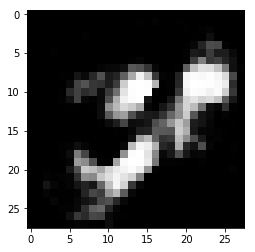

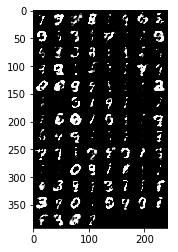

In [17]:
z = torch.randn(batch_size, z_dim).cuda()
fake_images = G(z)
plt.imshow((fake_images[2].cpu().view(28,28).data).numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid((fake_images.data.view(batch_size,1,28,28))).cpu().permute(1,2,0).numpy())
plt.show()